In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

In [2]:
from sklearn.metrics import matthews_corrcoef, f1_score, accuracy_score

In [3]:
df = pd.read_csv(r"C:\Users\pjroc\Projetos\Estudos_data_science\datasets\predictive_maintenance.csv")
df.head(5)

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,No Failure
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,No Failure
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,No Failure
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,No Failure
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,No Failure


In [4]:
df.shape

(10000, 10)

In [5]:
df['Failure Type'].value_counts() # Dados desbalanceados

No Failure                  9652
Heat Dissipation Failure     112
Power Failure                 95
Overstrain Failure            78
Tool Wear Failure             45
Random Failures               18
Name: Failure Type, dtype: int64

In [6]:
total_fail = df[df['Failure Type'] != 'No Failure']['Failure Type'].count()
print(f'% de falha em relação ao total do dataset: {total_fail/len(df)}' )
print(f"Soma de falhas registradas: {total_fail}")

% de falha em relação ao total do dataset: 0.0348
Soma de falhas registradas: 348


In [7]:
df = df.drop(['Product ID',"UDI"], axis=1)

In [8]:
df

,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type
0,M,298.1,308.6,1551,42.8,0,0,No Failure
1,L,298.2,308.7,1408,46.3,3,0,No Failure
2,L,298.1,308.5,1498,49.4,5,0,No Failure
3,L,298.2,308.6,1433,39.5,7,0,No Failure
4,L,298.2,308.7,1408,40.0,9,0,No Failure
...,...,...,...,...,...,...,...,...
9995,M,298.8,308.4,1604,29.5,14,0,No Failure
9996,H,298.9,308.4,1632,31.8,17,0,No Failure
9997,M,299.0,308.6,1645,33.4,22,0,No Failure
9998,H,299.0,308.7,1408,48.5,25,0,No Failure


# EDA 

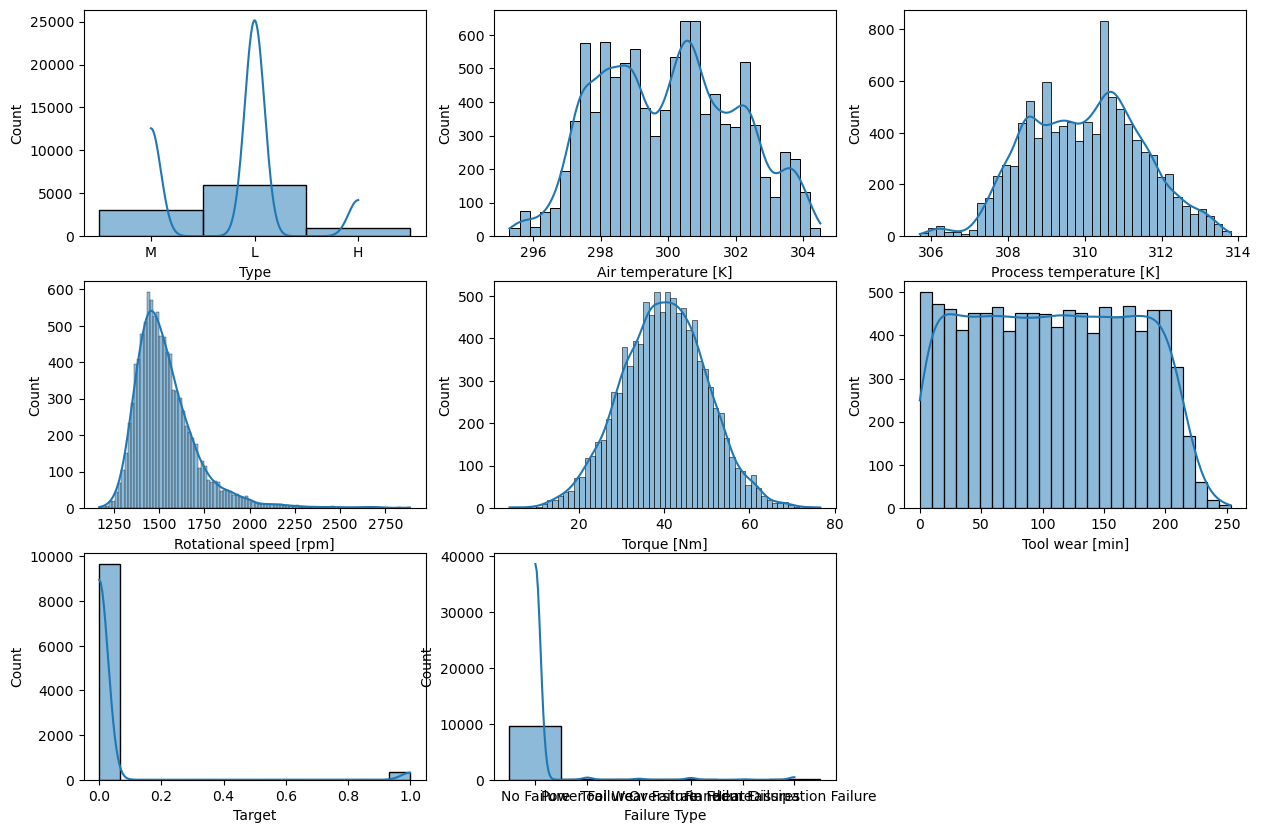

In [10]:
plt.figure(figsize=(15,10))
for i,col in enumerate(df.columns,1):
    plt.subplot(3,3,i)
    sns.histplot(df[col],kde=True)

In [11]:
df.describe()

,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,300.004930,310.005560,1538.776100,39.986910,107.951000,0.033900
std,2.000259,1.483734,179.284096,9.968934,63.654147,0.180981
min,295.300000,305.700000,1168.000000,3.800000,0.000000,0.000000
25%,298.300000,308.800000,1423.000000,33.200000,53.000000,0.000000
50%,300.100000,310.100000,1503.000000,40.100000,108.000000,0.000000
75%,301.500000,311.100000,1612.000000,46.800000,162.000000,0.000000
max,304.500000,313.800000,2886.000000,76.600000,253.000000,1.000000


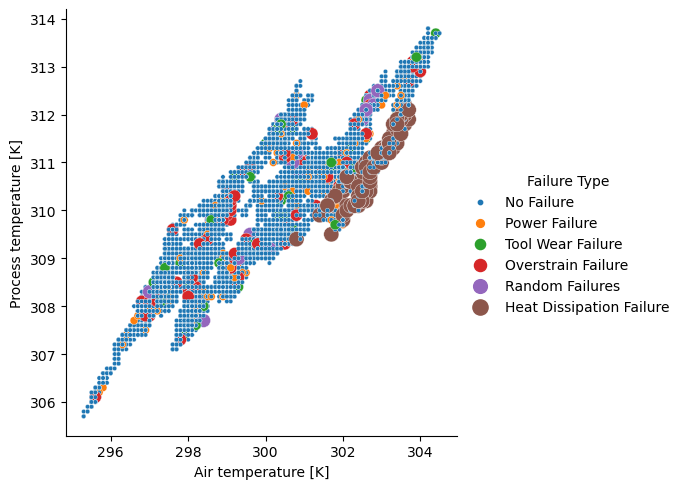

In [12]:
_ = sns.relplot(x="Air temperature [K]", y="Process temperature [K]", 
                hue="Failure Type",size="Failure Type", sizes=(120, 10), 
                data = df)

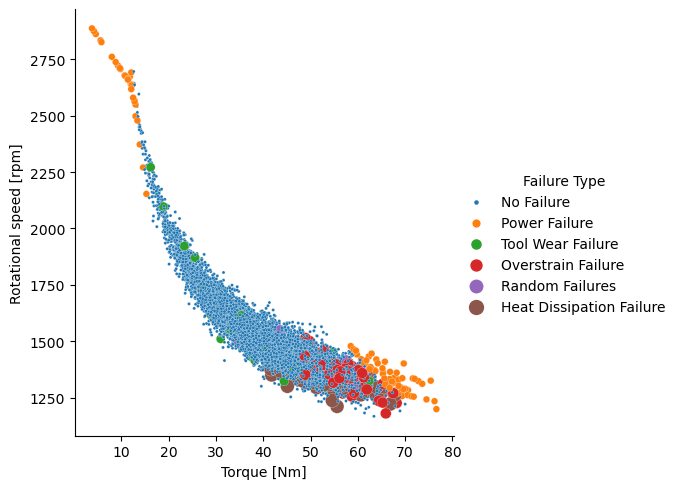

In [14]:
_ = sns.relplot(x="Torque [Nm]", y="Rotational speed [rpm]", 
                hue="Failure Type",size="Failure Type", 
                sizes=(100, 5),data=df)

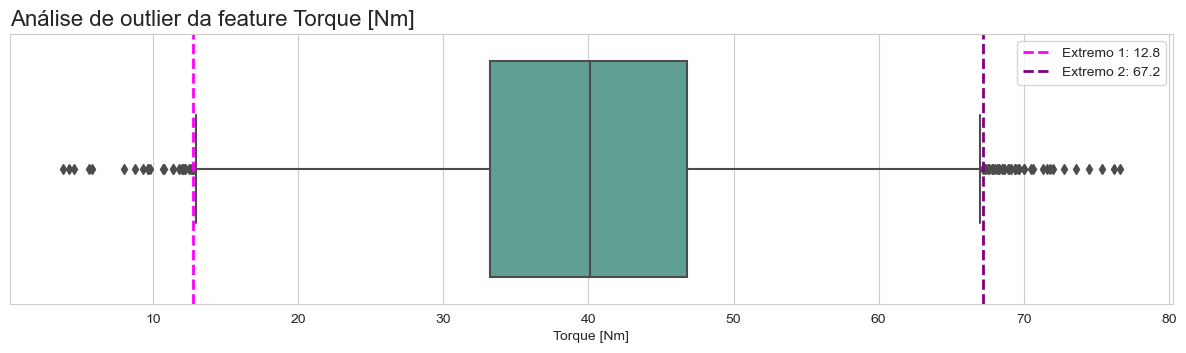

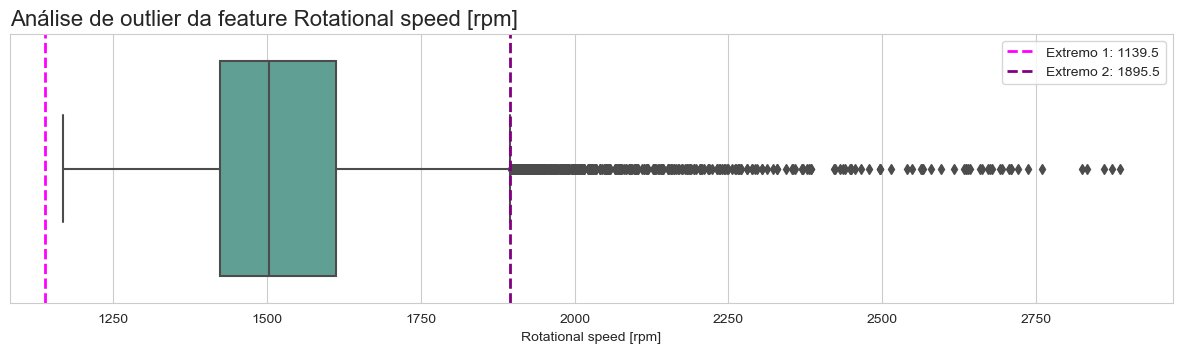

In [93]:
# Análise de outliers
sns.set_style("whitegrid")
def boxplot(feature):
    q1 = df[feature].quantile(0.25)
    q3 = df[feature].quantile(0.75)
    fig, ax = plt.subplots(figsize=(15, 3.5))
    sns.boxplot(data = df, x = feature, palette = "dark:#5A9_r")
    ax.axvline(x=q1-1.5*(q3-q1), 
           color='magenta', linestyle='--', linewidth=2, label='Extremo 1: {}'.format(round(q1-1.5*(q3-q1), 3)));
    ax.axvline(x=q3+1.5*(q3-q1), 
           color='purple', linestyle='--', linewidth=2, label='Extremo 2: {}'.format(round(q3+1.5*(q3-q1), 3)))
    plt.title(f"Análise de outlier da feature {feature}", loc ='left', size = 16)
    ax.legend()
    
    plt.show()

boxplot('Torque [Nm]')
boxplot('Rotational speed [rpm]')

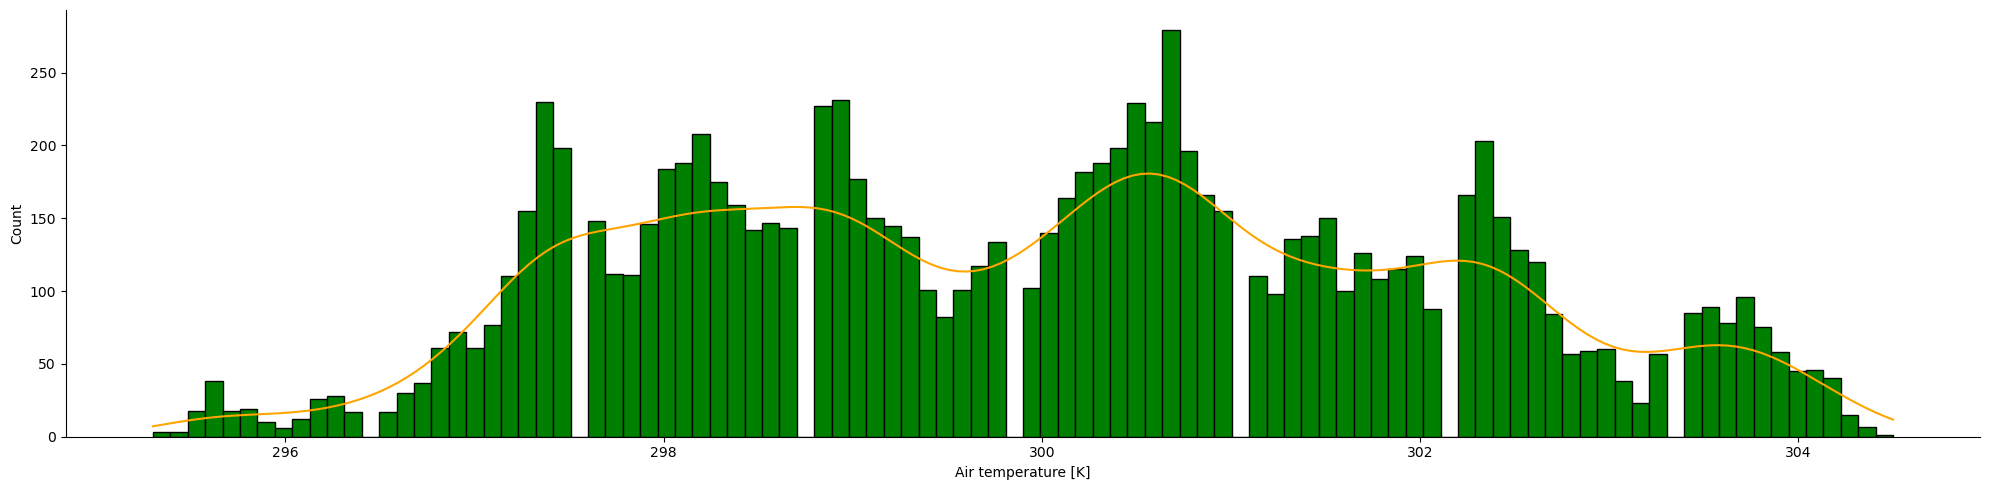

In [24]:
# Análise da temperatura
_ = sns.displot(data=df, x="Air temperature [K]", kde=True, 
            bins = 100,color = "orange", facecolor = "green",height = 5, aspect = 4);

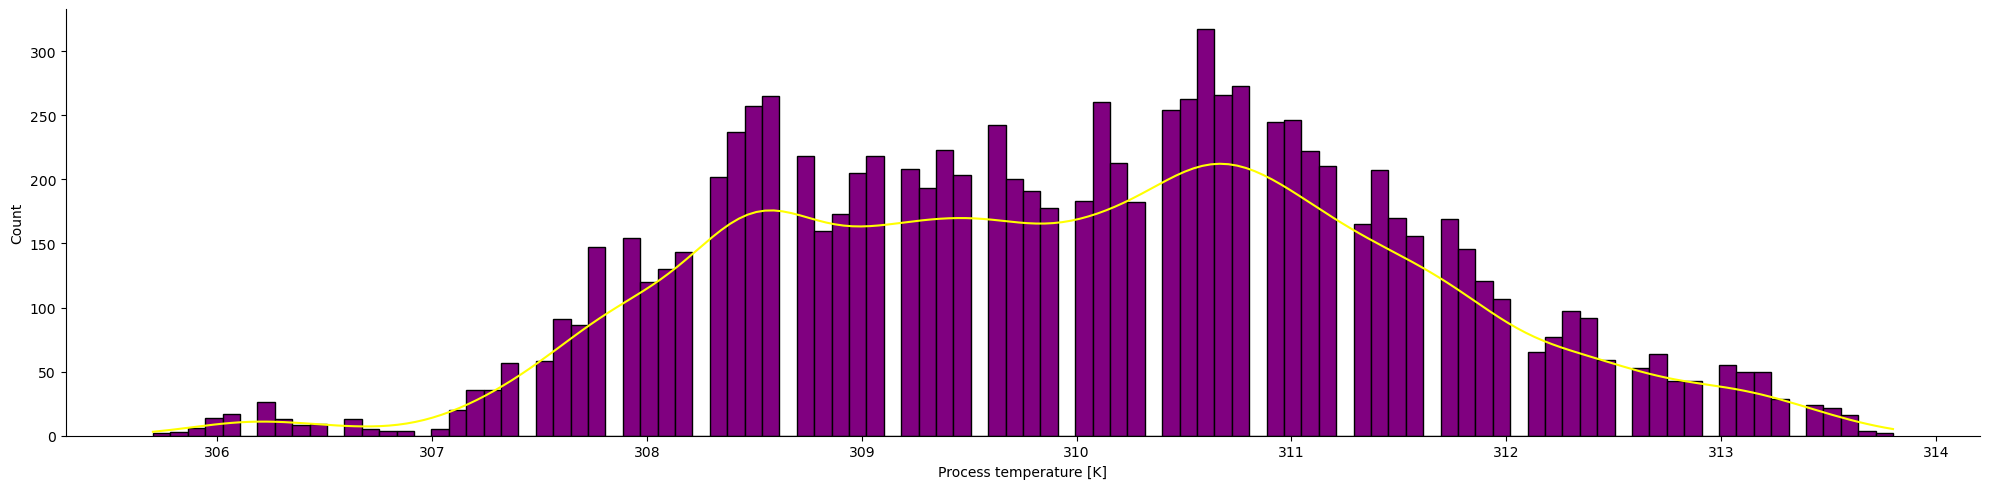

In [31]:
_ = sns.displot(data=df, x="Process temperature [K]", kde=True, 
            bins = 100,color = "yellow", facecolor = "purple",height = 5, aspect = 4);

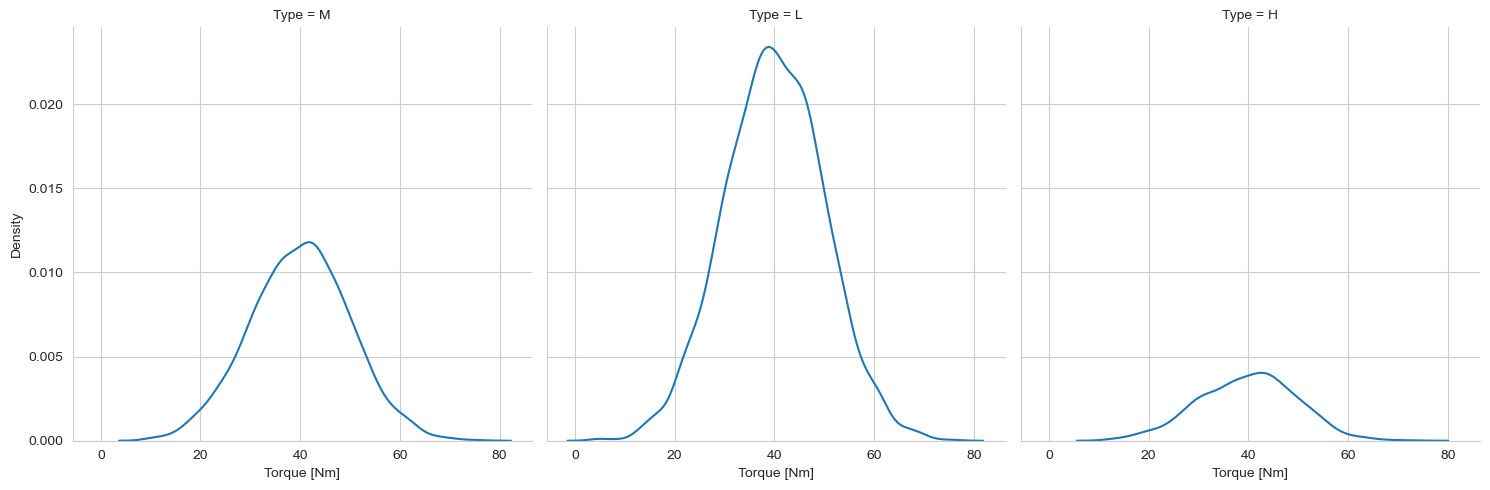

In [94]:
# Análise da velocidade de rotação por tipo
sns.displot(data=df, x="Torque [Nm]", col="Type", kind="kde");

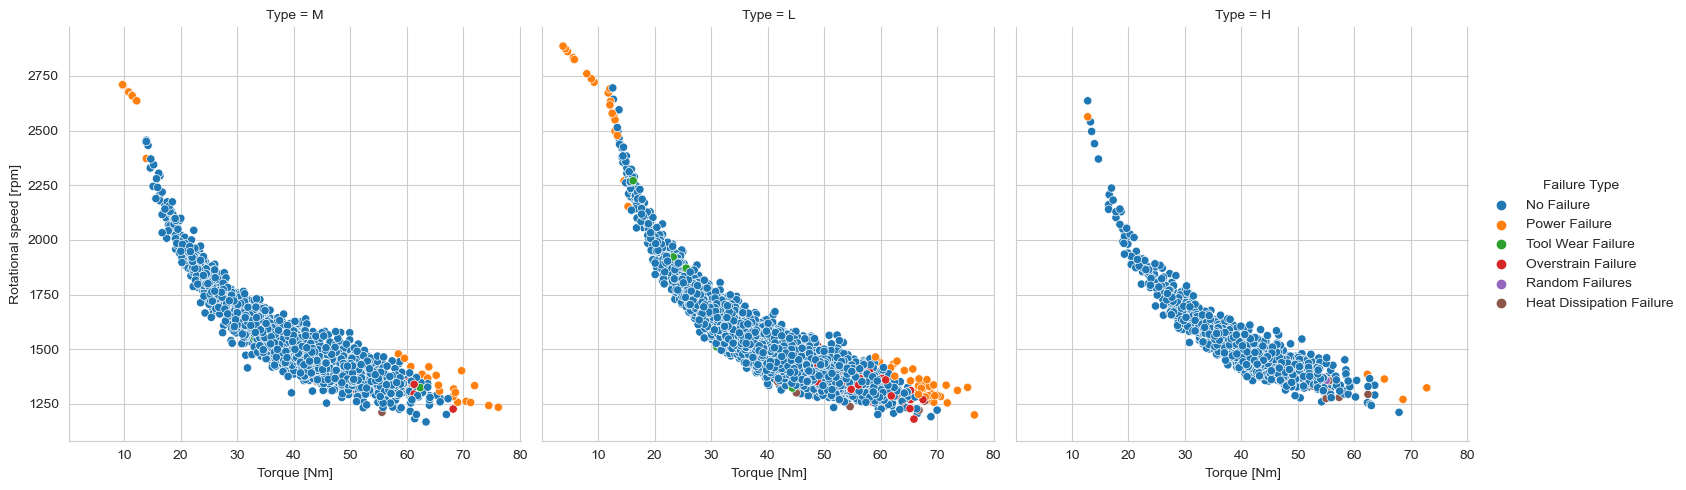

In [114]:
sns.relplot(data=df, x="Torque [Nm]", y="Rotational speed [rpm]", hue="Failure Type",col="Type");

# FEATURE ENGINEERING
- Criação de novas features 
- Ajuste de escala

In [9]:
# Conversão de Kelvin para °C 
# K = °C + 273.15 --> °C = K - 273.15
def convert_temp(feature):
    for features in feature: 
        df[features] = df[features] - 273.15
        new_feature_name = features.replace('[K]', '') + ' [°C]'
        
        df.rename(columns={features: new_feature_name}, inplace=True)
        
    return df

feature_to_convert = ['Air temperature [K]', 'Process temperature [K]']                  
df = convert_temp(feature_to_convert)

In [10]:
df

,Type,Air temperature [°C],Process temperature [°C],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type
0,M,24.95,35.45,1551,42.8,0,0,No Failure
1,L,25.05,35.55,1408,46.3,3,0,No Failure
2,L,24.95,35.35,1498,49.4,5,0,No Failure
3,L,25.05,35.45,1433,39.5,7,0,No Failure
4,L,25.05,35.55,1408,40.0,9,0,No Failure
...,...,...,...,...,...,...,...,...
9995,M,25.65,35.25,1604,29.5,14,0,No Failure
9996,H,25.75,35.25,1632,31.8,17,0,No Failure
9997,M,25.85,35.45,1645,33.4,22,0,No Failure
9998,H,25.85,35.55,1408,48.5,25,0,No Failure


In [11]:
# Criação de coluna com diferença de temperatura de processo e ambiente 
df['Temp_dif [°C]'] = df['Process temperature  [°C]'] - df['Air temperature  [°C]']

In [12]:
# Criação de coluna com potência --> Calculada pela velocidade de rotação * torque
# RPM = 360°*n/tempo
# RPM --> theta/minuto
df['Power [W]'] = df['Rotational speed [rpm]'] * df['Torque [Nm]']

In [13]:
df['Power [W]'] = df['Power [W]']/1000
df

,Type,Air temperature [°C],Process temperature [°C],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type,Temp_dif [°C],Power [W]
0,M,24.95,35.45,1551,42.8,0,0,No Failure,10.5,66.3828
1,L,25.05,35.55,1408,46.3,3,0,No Failure,10.5,65.1904
2,L,24.95,35.35,1498,49.4,5,0,No Failure,10.4,74.0012
3,L,25.05,35.45,1433,39.5,7,0,No Failure,10.4,56.6035
4,L,25.05,35.55,1408,40.0,9,0,No Failure,10.5,56.3200
...,...,...,...,...,...,...,...,...,...,...
9995,M,25.65,35.25,1604,29.5,14,0,No Failure,9.6,47.3180
9996,H,25.75,35.25,1632,31.8,17,0,No Failure,9.5,51.8976
9997,M,25.85,35.45,1645,33.4,22,0,No Failure,9.6,54.9430
9998,H,25.85,35.55,1408,48.5,25,0,No Failure,9.7,68.2880


In [14]:
df.rename(columns={'Power [W]' : 'Power [kW]'})

,Type,Air temperature [°C],Process temperature [°C],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type,Temp_dif [°C],Power [kW]
0,M,24.95,35.45,1551,42.8,0,0,No Failure,10.5,66.3828
1,L,25.05,35.55,1408,46.3,3,0,No Failure,10.5,65.1904
2,L,24.95,35.35,1498,49.4,5,0,No Failure,10.4,74.0012
3,L,25.05,35.45,1433,39.5,7,0,No Failure,10.4,56.6035
4,L,25.05,35.55,1408,40.0,9,0,No Failure,10.5,56.3200
...,...,...,...,...,...,...,...,...,...,...
9995,M,25.65,35.25,1604,29.5,14,0,No Failure,9.6,47.3180
9996,H,25.75,35.25,1632,31.8,17,0,No Failure,9.5,51.8976
9997,M,25.85,35.45,1645,33.4,22,0,No Failure,9.6,54.9430
9998,H,25.85,35.55,1408,48.5,25,0,No Failure,9.7,68.2880


# DIVISÂO E APLICAÇÃO DE ENCODERS

Apesar de termos diversos valores outliers, não será necessário colocá-los em escala pois estes na verdade são essenciais na detecção de problemas em máquinas, muitas vezes só percebemos uma falha pela alta temperatura ou alta rotação 

In [15]:
# Encoder nas features categóricas
from sklearn.preprocessing import OrdinalEncoder

categories = df[['Type', 'Failure Type']]

encoder = OrdinalEncoder()
encoded_categories = encoder.fit_transform(categories)

df[['Type', 'Failure Type']] = encoded_categories

df

,Type,Air temperature [°C],Process temperature [°C],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type,Temp_dif [°C],Power [W]
0,2.0,24.95,35.45,1551,42.8,0,0,1.0,10.5,66.3828
1,1.0,25.05,35.55,1408,46.3,3,0,1.0,10.5,65.1904
2,1.0,24.95,35.35,1498,49.4,5,0,1.0,10.4,74.0012
3,1.0,25.05,35.45,1433,39.5,7,0,1.0,10.4,56.6035
4,1.0,25.05,35.55,1408,40.0,9,0,1.0,10.5,56.3200
...,...,...,...,...,...,...,...,...,...,...
9995,2.0,25.65,35.25,1604,29.5,14,0,1.0,9.6,47.3180
9996,0.0,25.75,35.25,1632,31.8,17,0,1.0,9.5,51.8976
9997,2.0,25.85,35.45,1645,33.4,22,0,1.0,9.6,54.9430
9998,0.0,25.85,35.55,1408,48.5,25,0,1.0,9.7,68.2880


In [16]:
df = df.rename(columns={'Air temperature  [°C]' : 'air_temp', 'Process temperature  [°C]' : 'Process_temp',
                 'Rotational speed [rpm]' : 'Rot_speed', 'Torque [Nm]' : 'Torque', 'Tool wear [min]' : 'Tool_wear', 
                 'Temp_dif [°C]' : 'dif_temp', 'Power [W]' : 'Power'})

In [17]:
df.columns

Index(['Type', 'air_temp', 'Process_temp', 'Rot_speed', 'Torque', 'Tool_wear',
       'Target', 'Failure Type', 'dif_temp', 'Power'],
      dtype='object')

In [18]:
X = df.drop(columns='Failure Type', axis = 1)
y = df['Failure Type']

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

print(y_train.value_counts())
print(y_test.value_counts())

1.0    7722
0.0      90
3.0      76
2.0      62
5.0      36
4.0      14
Name: Failure Type, dtype: int64
1.0    1930
0.0      22
3.0      19
2.0      16
5.0       9
4.0       4
Name: Failure Type, dtype: int64


## Regressão Softmax

In [90]:
from sklearn.metrics import classification_report, confusion_matrix

Rlog = LogisticRegression(max_iter = 100000, solver ='sag', C= 10)

Rlog.fit(X_train, y_train)
y_predict_rlog = Rlog.predict(X_test)

l_score= round(Rlog.score(X_train, y_train), 3)
l_accuracy = round(accuracy_score(y_predict_rlog, y_test), 3)

print("Acurácia no treino: ",l_score)
print("Score de acurácia: ",l_accuracy)

l_mtt = matthews_corrcoef(y_test,y_predict_rlog)

print("Classification_Report: \n",classification_report(y_test,y_predict_rlog, zero_division=1))

Acurácia no treino:  0.974
Score de acurácia:  0.974
Classification_Report: 
               precision    recall  f1-score   support

         0.0       1.00      0.14      0.24        22
         1.0       0.98      1.00      0.99      1930
         2.0       0.85      0.69      0.76        16
         3.0       1.00      0.26      0.42        19
         4.0       1.00      0.00      0.00         4
         5.0       0.00      0.00      1.00         9

    accuracy                           0.97      2000
   macro avg       0.80      0.35      0.57      2000
weighted avg       0.97      0.97      0.97      2000



In [153]:
y_train.dtype

dtype('float64')

In [101]:
print("CCM: ", matthews_corrcoef(y_test,y_predict_rlog))

CCM:  0.5049127748069225


In [145]:
y_prob = Rlog.predict_proba(X_test)

## XGBoost

In [51]:
xgb = XGBClassifier()
xgb.fit(X_train, y_train)

y_predict_xgb = xgb.predict(X_test)

xgb_score= round(xgb.score(X_train, y_train), 3)
xgb_accuracy = round(accuracy_score(y_predict_xgb, y_test), 3)

print("Acurácia no treino: ", xgb_score)
print("Score de acurácia: ", xgb_accuracy)



print("Classification_Report: \n",classification_report(y_test, y_predict_xgb, zero_division=1))

Acurácia no treino:  1.0
Score de acurácia:  0.996
Classification_Report: 
               precision    recall  f1-score   support

         0.0       0.96      1.00      0.98        22
         1.0       1.00      1.00      1.00      1930
         2.0       1.00      0.75      0.86        16
         3.0       0.95      0.95      0.95        19
         4.0       1.00      0.00      0.00         4
         5.0       0.75      1.00      0.86         9

    accuracy                           1.00      2000
   macro avg       0.94      0.78      0.77      2000
weighted avg       1.00      1.00      0.99      2000



In [74]:
xgb_mtt = matthews_corrcoef(y_test,y_predict_xgb)
print("CCM: ", matthews_corrcoef(y_test,y_predict_xgb))

CCM:  0.932878772862212


## LGBM Classifier

In [73]:
from sklearn.metrics import classification_report, confusion_matrix
lgbm = LGBMClassifier(random_state=0, min_child_samples=100, max_depth = 1)
lgbm.fit(X_train, y_train)

y_predict_lgbm = lgbm.predict(X_test)

lgbm_score= round(lgbm.score(X_train, y_train), 3)
lgbm_accuracy = round(accuracy_score(y_predict_lgbm, y_test), 3)

print("Acurácia no treino: ", lgbm_score)
print("Score de acurácia: ", lgbm_accuracy)

print("Classification_Report: \n",classification_report(y_test, y_predict_lgbm, zero_division=1))

lgbm_mtt = matthews_corrcoef(y_test,y_predict_lgbm)

print("CCM: ", matthews_corrcoef(y_test,y_predict_lgbm))

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000415 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1263
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 9
[LightGBM] [Info] Start training from score -4.487387
[LightGBM] [Info] Start training from score -0.035368
[LightGBM] [Info] Start training from score -4.860062
[LightGBM] [Info] Start training from score -4.656463
[LightGBM] [Info] Start training from score -6.348139
[LightGBM] [Info] Start training from score -5.403678
Acurácia no treino:  0.998
Score de acurácia:  0.998
Classification_Report: 
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        22
         1.0       1.00      1.00      1.00      1930
         2.0       1.00      1.00      1.00        16
         3.0       1.00      1.00      1.00        19
         4.0       1.00      0.00      0

## DecisionTreeClassifier

In [68]:
Dtree = DecisionTreeClassifier()

Dtree.fit(X_train, y_train)

y_predict_dec = Dtree.predict(X_test)

dtree_score= round(Dtree.score(X_train, y_train), 3)
dtree_accuracy = round(accuracy_score(y_predict_dec, y_test), 3)

print("Acurácia no treino: ", dtree_score)
print("Score de acurácia: ", dtree_accuracy)

print("Classification_Report: \n",classification_report(y_test, y_predict_dec, zero_division=1))

print("CCM: ", matthews_corrcoef(y_test,y_predict_dec))

Acurácia no treino:  1.0
Score de acurácia:  0.995
Classification_Report: 
               precision    recall  f1-score   support

         0.0       0.96      1.00      0.98        22
         1.0       1.00      1.00      1.00      1930
         2.0       1.00      0.75      0.86        16
         3.0       1.00      1.00      1.00        19
         4.0       0.00      0.00      1.00         4
         5.0       0.82      1.00      0.90         9

    accuracy                           0.99      2000
   macro avg       0.80      0.79      0.96      2000
weighted avg       0.99      0.99      1.00      2000

CCM:  0.9256866217725382


In [78]:
dtree_mtt = matthews_corrcoef(y_test,y_predict_dec)

## SVM

In [99]:
svc = SVC(kernel = 'rbf', C = 15000)

svc.fit(X_train, y_train)
y_predict_svc = svc.predict(X_test)

svc_score= round(svc.score(X_train, y_train), 3)
svc_accuracy = round(accuracy_score(y_predict_svc, y_test), 3)

print("Acurácia no treino: ", svc_score)
print("Score de acurácia: ", svc_accuracy)

print("Classification_Report: \n",classification_report(y_test, y_predict_svc, zero_division=1))

svc_mtt = matthews_corrcoef(y_test,y_predict_svc)

print("CCM: ", svc_mtt)

Acurácia no treino:  0.99
Score de acurácia:  0.986
Classification_Report: 
               precision    recall  f1-score   support

         0.0       0.95      0.91      0.93        22
         1.0       0.99      1.00      0.99      1930
         2.0       0.68      0.94      0.79        16
         3.0       1.00      0.58      0.73        19
         4.0       1.00      0.00      0.00         4
         5.0       1.00      0.00      0.00         9

    accuracy                           0.99      2000
   macro avg       0.94      0.57      0.57      2000
weighted avg       0.99      0.99      0.98      2000

CCM:  0.7684745617993969


In [100]:
models = pd.DataFrame({
    'Model': [
        'SVM', 'Softmax', 'Árvore de decisão', 'LGBM',
        'XGBoost'
    ],
    
    'Training Accuracy':
    [svc_score, l_score, dtree_score, 
     lgbm_score, xgb_score],
    
    'Model Accuracy Score': [
        svc_accuracy, l_accuracy, dtree_accuracy, 
        lgbm_accuracy, xgb_accuracy],
    
    'Matthews_Coef' : [svc_mtt, l_mtt, dtree_mtt,
                       lgbm_mtt, xgb_mtt]
})

models

,Model,Training Accuracy,Model Accuracy Score,Matthews_Coef
0,SVM,0.990,0.986,0.768475
1,Softmax,0.974,0.974,0.504913
2,Árvore de decisão,1.000,0.995,0.925687
3,LGBM,0.998,0.998,0.970414
4,XGBoost,1.000,0.996,0.932879
